In [2]:
from __future__ import division, print_function, absolute_import

from collections import namedtuple
import itertools
import glob
import logging
import os

import numpy as np
from PIL import Image
import tensorflow as tf
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import windows as win
import fst3d_feat as fst

In [3]:
import scipy.io as sio
import operator
import h5py
import hdf5storage

In [4]:

DATA_PATH = '/scratch0/ilya/locDoc/data/hyperspec'
DATASET_PATH = '/scratch0/ilya/locDoc/data/hyperspec/datasets'

In [5]:
mat_contents = sio.loadmat(os.path.join(DATASET_PATH, 'Pavia_center_right'))
data = mat_contents['Pavia_center_right'].astype(np.float32)
data /= np.max(np.abs(data))
mat_contents = sio.loadmat(os.path.join(DATASET_PATH, 'Pavia_center_right_gt.mat'))
labels = mat_contents['Pavia_center_right_gt']
traintestfilename = 'Pavia_center_right_gt_traintest_coarse_128px128p.mat'
netO = fst.Pavia_net()

[height, width, nbands] = data.shape


all_pixels = np.array(list(itertools.product(range(width),range(height))))
flat_labels = labels.transpose().reshape(height*width)
# nlabels = len(set(flat_labels.tolist())) - 1

ap = np.array(netO.addl_padding)
assert np.all(ap % 2 == 0), 'Assymetric is not supported'
# net_in_shape = ap + np.array([1,1,nbands])
# x = tf.placeholder(tf.float32, shape=net_in_shape)
# feat = netO.model_fn(x)



In [6]:
padded_data = np.pad(data, ((ap[0]//2,ap[0]//2),(ap[1]//2,ap[1]//2),(ap[2]//2,ap[2]//2)), 'wrap')

In [7]:
mat_contents = None
try:
    mat_contents = sio.loadmat(os.path.join(DATA_PATH, traintestfilename))
except:
    mat_contents = hdf5storage.loadmat(os.path.join(DATA_PATH, traintestfilename))
train_mask = mat_contents['train_mask'].astype(int).squeeze()
test_mask = mat_contents['test_mask'].astype(int).squeeze()

In [8]:
train_pixels = np.array(filter(lambda (x,y): labels[y,x]*train_mask[x*height+y] != 0, all_pixels))
test_pixels = np.array(filter(lambda (x,y): labels[y,x]*test_mask[x*height+y] != 0, all_pixels))

In [9]:
test_pixels = np.array(filter(lambda (x,y): labels[y,x]*test_mask[x*height+y] != 0, all_pixels))

In [10]:
test_pixels.shape, test_mask.sum()

((90909, 2), 90909)

In [11]:
batch_item_shape = tuple(map(operator.add, netO.addl_padding, (1,1,data.shape[2])))
trainX = np.zeros((train_mask.sum(),) + batch_item_shape)
for pixel_i, pixel in enumerate(tqdm(train_pixels, desc='Train')):
    # this iterates through columns first
    [pixel_x, pixel_y] = pixel
    trainX[pixel_i,:,:,:] = padded_data[pixel_y:(pixel_y+ap[0]+1), pixel_x:(pixel_x+ap[1]+1), :]

Train: 100%|██████████| 12630/12630 [00:05<00:00, 2512.34it/s]


In [12]:
batch_item_shape = tuple(map(operator.add, netO.addl_padding, (1,1,data.shape[2])))
testX = np.zeros((test_mask.sum(),) + batch_item_shape)
for pixel_i, pixel in enumerate(tqdm(test_pixels)):
    # this iterates through columns first
    [pixel_x, pixel_y] = pixel
    testX[pixel_i,:,:,:] = padded_data[pixel_y:(pixel_y+ap[0]+1), pixel_x:(pixel_x+ap[1]+1), :]

100%|██████████| 90909/90909 [00:38<00:00, 2389.92it/s]


In [13]:
from fst3d_feat import scat3d

In [14]:
layerO = namedtuple('layerO', ['strides', 'padding'])

In [17]:
psi = win.fst3d_psi_factory([7,7,7])
phi = win.fst3d_phi_window_3D([7,7,7])
layer_params = layerO((3,1,1), 'valid')
psis=[psi,psi]
layer_params=[layer_params, layer_params, layer_params]

In [18]:
x = tf.placeholder(tf.float32, shape=(1,120,21,21,1))

In [19]:
U1 = scat3d(x, psis[0], layer_params[0])
# swap channels with batch
U1 = tf.transpose(U1, [4, 1, 2, 3, 0])

U2s = []
# only procede with increasing frequency paths
for res_i, used_params in enumerate(psis[0].filter_params):
    increasing_psi = win.fst3d_psi_factory(psis[1].kernel_size, used_params)
    if increasing_psi.nfilt > 0:
        U2s.append(scat3d(U1[res_i:(res_i+1),:,:,:,:], increasing_psi, layer_params[1]))

U2 = tf.concat(U2s, 4)
# swap channels with batch
U2 = tf.transpose(U2, [4, 1, 2, 3, 0])

# convolve with phis
S2 = scat3d(U2, phi, layer_params[2])

In [20]:
U1.shape

TensorShape([Dimension(216), Dimension(38), Dimension(15), Dimension(15), Dimension(1)])

In [21]:

def slice_idxs(sig_size, kernel_size):
    def slice_idx(s, k, f):
        if k % 2 == 0:
            raise('not implemented even padding')
        else:
            return int((s - k - f)//2)
    final_size = [1,3,3]
    return [slice_idx(s,k,f-1) for s,k,f in zip(sig_size, kernel_size,final_size)]

In [22]:
[p1b, p1h, p1w] = slice_idxs(U1.shape[1:4], psis[1].kernel_size)
[p2b, p2h, p2w] = slice_idxs(x.shape[1:4], psis[0].kernel_size)

In [23]:
S1 = scat3d(U1[:,(p1b):-(p1b),(p1h):-(p1h), (p1w):-(p1w), :], phi, layer_params[2])
S0 = scat3d(x[:, (p2b):-(p2b),(p2h):-(p2h), (p2w):-(p2w), :], phi, layer_params[2])

In [24]:
S0.shape

TensorShape([Dimension(1), Dimension(1), Dimension(3), Dimension(3), Dimension(1)])

In [25]:
S1.shape

TensorShape([Dimension(216), Dimension(1), Dimension(3), Dimension(3), Dimension(1)])

In [26]:
S2.shape

TensorShape([Dimension(9045), Dimension(2), Dimension(3), Dimension(3), Dimension(1)])

In [27]:
S2 = tf.reduce_mean(S2,1,keepdims=True)

In [28]:
SX = tf.squeeze(tf.concat([S0,S1,S2], 0))

In [29]:
SX_batch = tf.expand_dims(SX,0)

In [30]:
n_classes = 9
dropout = 0.25 # Dropout, probability to drop a unit
is_training=True

In [31]:
arr = np.load('/scratch0/ilya/locDownloads/tmp_coef.npy')

KeyboardInterrupt: 

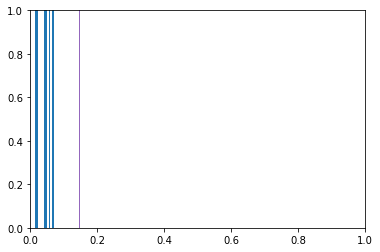

In [32]:
plt.hist(arr)